# Geometric Series, Fixed Points, and Asset Pricing

Undergraduate Computational Macro

Jesse Perla (University of British Columbia)

# Overview

## Motivation and Materials

-   In this lecture, we will introduce **fixed points**, practice a
    little Julia coding, move on to **geometric series**
-   The applications will be to **asset pricing** and **Keynesian
    multipliers**
    -   Asset pricing, in particular, will be something we come back to
        repeatedly as a way to practice our tools
-   Even for those not interested in finance, you will see that many
    problems are tightly related to asset pricing
    -   Human capital accumulation, choosing when to accept jobs, etc.

## Materials

-   Adapted from QuantEcon lectures coauthored with John Stachurski and
    Thomas J. Sargent
    -   [Julia by
        Example](https://julia.quantecon.org/getting_started_julia/julia_by_example.html)
    -   [Geometric Series for Elementary
        Economics](https://julia.quantecon.org/tools_and_techniques/geom_series.html)

In [1]:
using LinearAlgebra, Statistics, Plots, Random, Distributions, LaTeXStrings
default(;legendfontsize=16)

# Intro to Fixed Points

## Fixed Points

-   Fixed points are everywhere!
    -   Lets first look at the mechanics and practice code, then apply
        them.
-   Take a mapping $f : X \to X$ for some set $X$.
    -   If there exists an $x^* \in X$ such that $f(x^*) = x^*$, then
        $x^*$: is called a “fixed point” of $f$
-   A fixed point is a property of a function, and may not be unique
-   Lets walk through the math, and then practice a little more Julia
    coding with them

## Simple, Linear Example

-   For given scalars $y,\beta$ and a scalar $v$ of interest

$$
v = y + \beta v
$$

-   If $|\beta| < 1$, then this can can be solved in closed form as
    $v = y/(1 - \beta)$
-   Rearrange the equation in terms of a map
    $f : \mathbb R \to \mathbb R$

$$
f(v) := y + \beta v
$$

-   Therefore, a fixed point $f(\cdot)$ is a solution to the above
    problem such that $v = f(v)$

## Fixed Point Iteration

-   Consider iteration of the map $f$ starting from an initial condition
    $v_0$

    $$
    v_{n+1} = f(v_n)
    $$

-   Does this converge? Depends on $f(\cdot)$, as we will explore in
    detail

    -   It shouldn’t depend on $v_0$ or there is an issue

-   See [Banach’s fixed-point
    theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem)

## When to Stop Iterating?

-   If $v_n$ is a scalar, then we can check convergence by looking at
    $|v_{n+1} - v_n|$ with some threshold, which may be problem
    dependent
    -   If $v_n$ will be a vector, so we should use a norm
        $||v_{n+1} - v_n||$
    -   e.g. the Euclidean norm, `norm(v_new - v_old)` in Julia
-   Keep numerical precision in mind! Can see this in Julia with the
    following

In [2]:
@show eps() #machine epsilon, the smallest number such that 1.0 + eps() > 1.0
@show 1.0 + eps()/2 > 1.0;

eps() = 2.220446049250313e-16
1.0 + eps() / 2 > 1.0 = false


## Verifying with the Linear Example

-   For our simple linear map: $f(v) \equiv y + \beta v$

-   Iteration becomes $v_{n+1} = y + \beta v_n$. Iterating backwards $$
    v_{n+1} = y + \beta v_n = y + \beta y + \beta^2 v_{n-1} = y \sum_{i=0}^{n-1} \beta^i + \beta^n v_0
    $$

    -   $\sum_{i=0}^{n-1} \beta^i = \frac{1 - \beta^n}{1 - \beta}$ and
        $\sum_{i=0}^{\infty} \beta^i = \frac{1}{1 - \beta}$ if
        $|\beta| < 1$
    -   So $n \to \infty$, converges to $v = y/(1 - \beta)$ for all
        $v_0$

## Implementing with For Loop

In [3]:
y = 1.0
beta = 0.9
v_iv = 0.8 # initial condition
v_old = v_iv
normdiff = Inf
iter = 1
for i in 1:1000
    v_new = y + beta * v_old # the f(v) map
    normdiff = norm(v_new - v_old)
    if normdiff < 1.0E-7 # check convergence
        iter = i
        break # converged, exit loop
    end
    v_old = v_new # replace and continue
end
println("Fixed point = $v_old  |f(x) - x| = $normdiff in $iter iterations");

Fixed point = 9.999999081896231  |f(x) - x| = 9.181037796679448e-8 in 154 iterations


## Implementing in Julia with While Loop

In [4]:
v_old = v_iv
normdiff = Inf
iter = 1
while normdiff > 1.0E-7 && iter <= 1000
    v_new = y + beta * v_old # the f(v) map
    normdiff = norm(v_new - v_old)
    v_old = v_new # replace and continue
    iter = iter + 1
end
println("Fixed point = $v_old  |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999173706609  |f(x) - x| = 9.181037796679448e-8 in 155 iterations


## Avoid Global Variables

In [5]:
function v_fp(beta, y, v_iv; tolerance = 1.0E-7, maxiter=1000)
    v_old = v_iv
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        v_new = y + beta * v_old # the f(v) map
        normdiff = norm(v_new - v_old)
        v_old = v_new
        iter = iter + 1
    end
    return (v_old, normdiff, iter) # returns a tuple
end
y = 1.0
beta = 0.9
v_star, normdiff, iter = v_fp(beta, y, 0.8)
println("Fixed point = $v_star |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999173706609 |f(x) - x| = 9.181037796679448e-8 in 155 iterations


## Use a Higher Order Function and Named Tuple

-   Why hardcode the mapping? Pass it in as a function
-   Lets add in keyword arguments and use a named tuple for clarity

In [6]:
function fixedpointmap(f, iv; tolerance = 1.0E-7, maxiter=1000)
    x_old = iv
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = f(x_old) # use the passed in map
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (; value = x_old, normdiff, iter) # A named tuple
end

fixedpointmap (generic function with 1 method)

## Passing in a Function

In [7]:
y = 1.0
beta = 0.9
v_initial = 0.8
f(v) = y + beta * v # note that y and beta are used in the function!
sol = fixedpointmap(f, 0.8; tolerance = 1.0E-8) # don't need to pass
println("Fixed point = $(sol.value) |f(x) - x| = $(sol.normdiff) in $(sol.iter) iterations")

# Or use unpacking notation for the tuples, using anonymous function
(; value, normdiff, iter) = fixedpointmap(v -> y + beta * v, # creates an anonymous "closure"
                                          v_initial; tolerance = 1.0E-8)
println("Fixed point = $value |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999918629035 |f(x) - x| = 9.041219328764782e-9 in 177 iterations
Fixed point = 9.999999918629035 |f(x) - x| = 9.041219328764782e-9 in 177 iterations


## Other Algorithms

-   VFI is instructive, but not always the fastest
-   Can also write as a “root finding” problem
    -   i.e. $\hat{f}(x) \equiv f(x) - x$ so that $\hat{f}(x^*) = 0$ is
        the fixed point
    -   These can be especially fast if $\nabla \hat{f}(\cdot)$ is
        available
-   Another is called Anderson Acceleration
    -   The fixed-point iteration we have above is a special case

## Use Packages with Better Algorithms

-   [NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl/) has
    equations for solving equations (and fixed points)
    -   e.g., 3 iterations, not 177, for Andersen Acceleration
-   Uses multi-dimensional maps, so can write in that way rather than
    scalar

In [8]:
using NLsolve
# best style
y = 1.0
beta = 0.9
iv = [0.8] # note move to array
f(v) = y .+ beta * v # note that y and beta are used in the function!
sol = fixedpoint(f, iv) # uses Anderson Acceleration
fnorm = norm(f(sol.zero) .- sol.zero)
println("Fixed point = $(sol.zero) |f(x) - x| = $fnorm  in $(sol.iterations) iterations")

Fixed point = [9.999999999999972] |f(x) - x| = 3.552713678800501e-15  in 3 iterations


# Geometric Series and PDVs

## Geometric Series

-   Finite geometric series

$$
1 + c + c^2 + c^3 + \cdots + c^T  = \frac{1 - c^{T+1}}{1-c}
$$

-   Infinite geometric series, requiring $|c| < 1$

$$
1 + c + c^2 + c^3 + \cdots = \frac{1}{1 -c }
$$

## Discounting

-   In discrete time, $t = 0, 1, 2, \ldots$
-   Let $r > 0$ be a one-period **net nominal interest rate**
-   A one-period **gross nominal interest rate** $R$ is defined as $$
    R = 1 + r > 1
    $$
-   If the nominal interest rate is $5$ percent, then $r= 0.05$ and
    $R = 1.05$

## Interpretation as Prices

-   The gross nominal interest rate $R$ is an **exchange rate** or
    **relative price** of dollars at between times $t$ and $t+1$. The
    units of $R$ are dollars at time $t+1$ per dollar at time $t$.
-   When people borrow and lend, they trade dollars now for dollars
    later or dollars later for dollars now.
-   The price at which these exchanges occur is the gross nominal
    interest rate.
    -   If I sell $x$ dollars to you today, you pay me $R x$ dollars
        tomorrow.
    -   This means that you borrowed $x$ dollars for me at a gross
        interest rate $R$ and a net interest rate $r$.
-   In equilibrium, the prices for borrowing and lending should be
    related

## Where do Interest Rates Come From?

-   More later, but consider connection to a discount factor
    $\beta \in (0,1)$ in **consumer preferences**
-   This represents how much consumers value future consumption tomorrow
    relative to today
-   In some simple cases $R^{-1} = \beta$ makes sense
    -   Much more later, including how to think about cases with
        randomness
-   For now, just use $R^{-1}$ directly as a discount factor, thinking
    about risk-neutrality

## Accumulation

-   $x, x R, x R^2, \cdots$ tells us how investment of $x$ dollar value
    of an investment **accumulate** through time. Compounding
-   Reinvested in the project (i.e., compounding)
    -   thus, $1$ dollar invested at time $0$ pays interest $r$ dollars
        after one period, so we have $r+1 = R$ dollars at time $1$
    -   at time $1$ we reinvest $1+r =R$ dollars and receive interest of
        $r R$ dollars at time $2$ plus the **principal** $R$ dollars, so
        we receive $r R + R = (1+r)R = R^2$ dollars at the end of period
        $2$

## Discounting

-   $1, R^{-1}, R^{-2}, \cdots$ tells us how to **discount** future
    dollars to get their values in terms of today’s dollars.
-   Tells us how much future dollars are worth in terms of today’s
    dollars.
-   Remember that the units of $R$ are dollars at $t+1$ per dollar at
    $t$.
    -   the units of $R^{-1}$ are dollars at $t$ per dollar at $t+1$
    -   the units of $R^{-2}$ are dollars at $t$ per dollar at $t+2$
    -   and so on; the units of $R^{-j}$ are dollars at $t$ per dollar
        at $t+j$

## Asset Pricing

-   An asset has payments stream of $y_t$ dollars at times
    $t = 0, 1, 2, \ldots, G \equiv 1+g, g > 0$ and $G < R \equiv 1 + r$

    $$
    y_t = G^t y_0
    $$

    -   i.e. grows at $g$ percent, discounted at $r$ percent

-   The **present value** of the asset is

    $$
    \begin{aligned} 
    p_0  & = y_0 + y_1/R + y_2/(R^2) + \cdots = \sum_{t=0}^{\infty} y_t (1/R)^t = \sum_{t=0}^{\infty} y_0 G^t (1/R)^t \\
    &= \sum_{t=0}^{\infty} y_0 (G/R)^t = y_0/(1 - G R^{-1})
    \end{aligned}
    $$

## Gordon Formula

-   For small $r$ and $g$, use a Taylor series or $r g \approx 0$ to get

    $$
    G R^{-1} \approx 1 + g - r
    $$

-   Hence,

$$
p_0  = y_0/(1 - (1+g)/(1+r)) \approx y_0 / (r - g)
$$

## Assets with Finite Lives

-   Consider an asset that pays $y_t = 0$ for $t > T$ and
    $y_t = G^t y_0$ for $t \leq T$

    -   i.e., the same process but truncated it $T$ periods

-   The present value is

    $$
    \begin{aligned} 
    p_0  &= \sum_{t=0}^{T} y_t (1/R)^t = \sum_{t=0}^{T} y_0 G^t (1/R)^t \\
    &= \sum_{t=0}^{T} y_0 (G/R)^t = y_0\frac{1 - (G/R)^{T+1}}{1 - G/R}
    \end{aligned}
    $$

-   How large is $(G/R)^{T+1}$?

    -   If small, then infinite horizon may be a good approximation

## Is Infinite Horizon a Reasonable Approximation?

-   Implement these in code to compare

In [9]:
infinite_payoffs(g, r, y_0) = y_0 / (1 - (1 + g) * (1 + r)^(-1))
function finite_payoffs(T, g, r, y_0)
    G = 1 + g
    R = 1 + r
    return (y_0 * (1 - G^(T + 1) * R^(-T - 1))) / (1 - G * R^(-1))
end
@show infinite_payoffs(0.01, 0.05, 1.0)
@show finite_payoffs(100, 0.01, 0.05, 1.0);

infinite_payoffs(0.01, 0.05, 1.0) = 26.24999999999994
finite_payoffs(100, 0.01, 0.05, 1.0) = 25.73063957477331


## Comparing Different Horizons

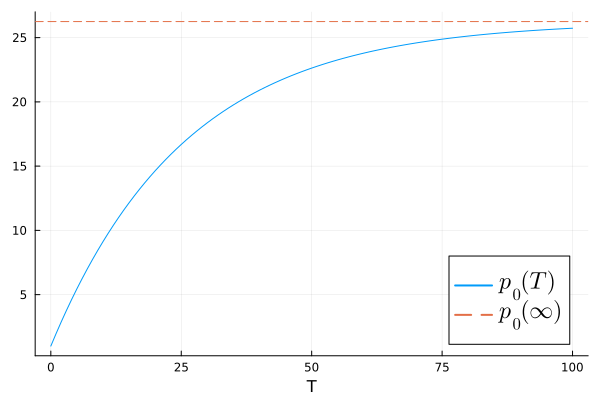

In [10]:
g = 0.01
r = 0.05
y_0 = 1.0
T = 100
# broadcast over 0:T
p_finite = finite_payoffs.(0:T, g, r, y_0)
p_infinite = infinite_payoffs(g, r, y_0)
plot(0:T, p_finite,xlabel = "T",
     label= L"p_0(T)", size = (600,400))
hline!([p_infinite], linestyle = :dash,
       label = L"p_0(\infty)")

## Discounting vs. Growth

-   For $T = \infty$, we assumed that $G R^{-1} < 1$, or approximately
    $g < r$

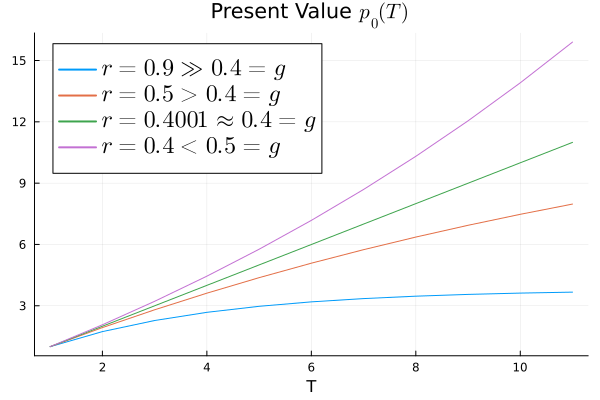

In [11]:
T = 10
y_0 = 1.0
plot(title = L"Present Value $p_0(T)$", legend = :topleft, xlabel = "T")
plot!(finite_payoffs.(0:T, 0.4, 0.9, y_0),
      label = L"r=0.9 \gg 0.4 = g")
plot!(finite_payoffs.(0:T, 0.4, 0.5, y_0), label = L"r=0.5 > 0.4 = g")
plot!(finite_payoffs.(0:T, 0.4, 0.4001, y_0),
      label = L"r=0.4001 \approx 0.4 = g")
plot!(finite_payoffs.(0:T, 0.5, 0.4, y_0), label = L"r=0.4 < 0.5 = g")

# Asset Pricing and Fixed Points

## Rewriting our Problem

-   Lets write a version of the model for arbitrary $y_t$ and relabel
    $\beta \equiv 1/R$

-   The asset price, $p_t$ starting at any $t$

    $$
    \begin{aligned}
    p_t &= \sum_{j = 0}^{\infty}\beta^j y_{t+j}\\
    p_t &= y_t + \beta y_{t+1} + \beta^2 y_{t+2} + \beta^3 y_{t+3} + \cdots\\
    &= y_t + \beta \left(y_{t+1} + \beta y_{t+2} + \beta^2 y_{t+2} \cdots\right)\\
    &= y_t + \beta \sum_{j=0}^{\infty} y_{t+j+1}\\
    &= y_t + \beta p_{t+1}
    \end{aligned}
    $$
    

    $$
    \begin{aligned}
    p_t &= \sum_{j = 0}^{\infty}\beta^j y_{t+j}\\
    p_t &= y_t + \beta y_{t+1} + \beta^2 y_{t+2} + \beta^3 y_{t+3} + \cdots\\
    &= y_t + \beta \left(y_{t+1} + \beta y_{t+2} + \beta^2 y_{t+2} \cdots\right)\\
    &= y_t + \beta \sum_{j = 0}^{\infty}\beta^j y_{t+j+1}\\
    &= y_t + \beta p_{t+1}
    \end{aligned}
    $$
    

## Recursive Formulation

-   In the simple case of $y_t = \bar{y}$, recursive equation is

    $$
    p_t = \bar{y} + \beta p_{t+1}
    $$

    -   We could also check that $p_t = \frac{\bar{y}}{1 - \beta}$
        fulfills this equation
    -   There are be other $p_t$ which fulfill it, but we won’t explore
        that here

-   In cases where the price is time-invariant, write this as a fixed
    point

$$
p = \bar{y} + \beta p \equiv f(p)
$$

## Recursive Interpretation

$$
p_t = y_t + \beta p_{t+1}
$$

-   The price $p_t$ is the sum of
    -   The payoffs you get that period
    -   The discounted price of how much you can sell it next period
-   The $p_{t+1}$ is the **forecast** of the price tomorrow
    -   Here we are assuming the forecasts are perfect, as
        $\{y_t\}_{t=0}^{\infty}$ is known
-   More generally, want expected price tomorrow using some
    probabilities

## Solving Numerically

In [18]:
y_bar = 1.0
beta = 0.9
iv = [0.8]
f(p) = y_bar .+ beta * p
sol = fixedpoint(f, iv) # uses Anderson Acceleration
@show y_bar/(1 - beta), sol.zero;

(y_bar / (1 - beta), sol.zero) = (10.000000000000002, [9.999999999999972])


## A More Complicated Example

-   Instead $\bar{y}$, asset may pay $y_L$ or $y_H$
    -   You don’t know the payoff $y_{t+1}$ until $t+1$ occurs
    -   You need to assign some probabilities of each occurring. e.g.,
        equal
-   As with the previous example, lets assume you hold onto the asset
    only a single period, then sell it
    -   Naturally, the value of the asset to both you and others depends
        on $y_{t+1}$
    -   We will see much more in [future
        lectures](https://julia.quantecon.org/multi_agent_models/markov_asset.html)
-   Hint: in future lectures will use mathematical expectations

$$
p_t = y_t + \beta \mathbb{E}\left[p_{t+1}\right]
$$

## Recursive Formulation

-   Assume two prices: $p_L$ and $p_H$ for the asset depending on the
    $y_t$ $$
    \begin{aligned}
    p_L &= y_L + \beta \left[ 0.5 p_L + 0.5 p_H \right]\\
    p_H &= y_H + \beta \left[ 0.5 p_L + 0.5 p_H \right]
    \end{aligned}
    $$

-   Stack $p \equiv \begin{bmatrix} p_L & p_H \end{bmatrix}^{\top}$ and
    $y \equiv \begin{bmatrix} y_L & y_H \end{bmatrix}^{\top}$

    $$
    p = y + \beta \begin{bmatrix} 0.5 & 0.5 \\ 0.5 & 0.5 \end{bmatrix} p\equiv f(p)
    $$

    -   We will see later how to write as a mathematical expectation

-   We could solve this as a linear equation, but lets use a fixed point

## Solving Numerically with a Fixed Point

In [13]:
y = [0.5, 1.5] #y_L, y_H
beta = 0.9
iv = [0.8, 0.8]
A = [0.5 0.5; 0.5 0.5]
sol = fixedpoint(p -> y .+ beta * A * p, iv) # f(p) := y + beta A p
p_L, p_H = sol.zero # can unpack a vector
@show p_L, p_H, sol.iterations
# p = y + beta A p =>  (I - beta A) p = y => p = (I - beta A)^{-1} y
@show (I - beta * A) \ y; # or $inv(I - beta * A) * y

(p_L, p_H, sol.iterations) = (9.500000000000028, 10.500000000000028, 4)
(I - beta * A) \ y = [9.499999999999996, 10.499999999999996]


# Keynesian Multipliers

## Model without Prices

-   $c$: **consumption**, $i$: **investment**, $g$: **government
    expenditures**, $y$ **national income**
-   Prices don’t adjust/exit to clear markets
    -   **Excess supply** of labor and capital (unemployment and unused
        capital)
    -   Prices and interest rates fail to adjust to make aggregate
        **supply equal demand** (e.g., prices and interest rates are
        frozen)
    -   National income entirely determined by aggregate demand,
        $\uparrow c\implies \uparrow y$

## Simple Model

-   **Assume**: consume a fixed fraction $0 < b < 1$ of the national
    income $y_t$
    -   $b$ is the **marginal propensity to consume (MPC)**
    -   $1-b$ is the **marginal propensity to save**
    -   Modern macro would have $b$ adjust to reflect prices, consumer
        preferences, etc. and add in prices/production functions
-   Leads to three equations in this basic model
    -   An accounting identity for the national income, the investment
        choice, and the consumer choice above

## Equations

-   **National income** is an accounting identity: the sum of
    consumption, investment, and government expenditures is the national
    income

    $$
    y_t = c_t + i_t + g_t
    $$

-   **Investment** is the sum of private investment and government
    investment. Assume it is fixed here at $i$ and $g$

-   **Consumption** $c_t = b y_{t-1}$, i.e. lag on last periods
    income/output

## Dynamics of Income and Consumption

-   Substituting the consumption equation into the national income
    equation

    $$
    \begin{aligned}
    y_t &= c_t + i + g\\
    y_t &= b y_{t-1} + i + g\\
    y_t &= b (b y_{t-2} + i + g) + i + g\\
    y_t &= b^2 y_{t-2} + b (i + g) + (i + g)
    \end{aligned}
    $$

-   Iterative backwards to a $y_0$,

$$
y_t = \sum_{j=0}^{t-1} b^j (i + g) + b^t y_0 = \frac{1 - b^{t}}{1 - b} (i + g) + b^t y_0
$$

## Keynesian Multiplier

-   Take limit as $t \to \infty$ to get

    $$
    \lim_{t\to\infty}y_t = \frac{1}{1 - b} (i + g)
    $$

-   Define the **Keynesian multiplier** is $1/(1-b)$

    -   More consumption delivers higher income, which delivers more
        consumption, compounding…
    -   $i \to i + \Delta$ implies $y \to y + \Delta/(1-b)$. Same with
        $g$

-   Is this correct (or useful) of a model?

    -   Probably not…gives intuition for more believable models
    -   Lets us practice difference equations

## Iterating the Difference Equations

$$
y_t = b y_{t-1} + i + g
$$

In [14]:
function calculate_y(i, b, g, T, y_0)
    y = zeros(T + 1)
    y[1] = i + b * y_0 + g
    for t in 2:(T + 1)
        y[t] = b * y[t - 1] + i + g
    end
    return y
end
y_limit(i, b, g) = (i + g) / (1 - b)

y_limit (generic function with 1 method)

## Plotting Dynamics

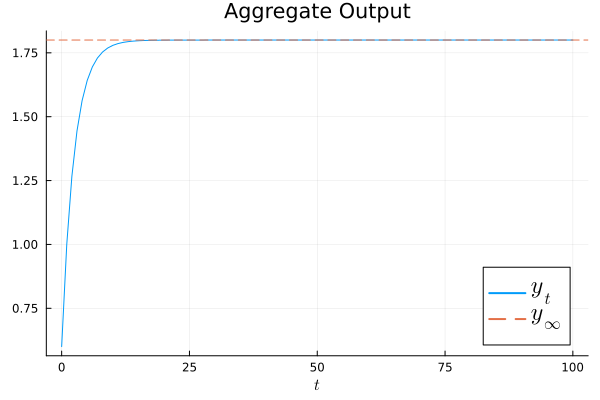

In [15]:
i_0 = 0.3
g_0 = 0.3
b = 2/3 # = MPC out of income
y_0 = 0
T = 100
plot(0: T,calculate_y(i_0, b, g_0, T, y_0);
     title = "Aggregate Output",
     size=(600,400), xlabel = L"t",
     label = L"y_t")
hline!([y_limit(i_0, b, g_0)];
       linestyle = :dash,
       label = L"y_{\infty}")

## MPCs

-   Suggests that national output, $y_t$ is increasing in MPC, $b$, due
    to multiplier
-   To increase the longrun size of economy, decrease the savings rate
    ($1-b$)!

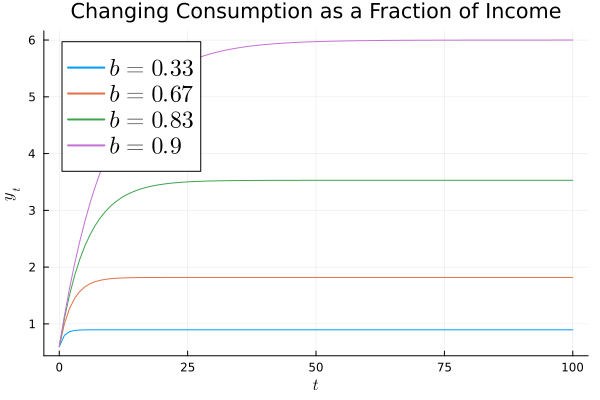

In [16]:
bs = round.([1 / 3, 2 / 3, 5 / 6, 0.9], digits = 2)
plt = plot(title = "Changing Consumption as a Fraction of Income",
           xlabel = L"t", ylabel = L"y_t", legend = :topleft)
[plot!(plt, 0:T, calculate_y(i_0, b, g_0, T, y_0), label = L"b = %$b")
 for b in bs]
plt

## Can Governments (Magically) Expand Output?

-   Remember the limitation is that demand is too low and there is
    excess supply of labor and/or capital
-   What if the government increases $g$ by $\Delta$?
    -   $y \to y + \Delta/(1-b)$
-   Assume we start at the $y_{\infty}$ for the $g=0.3$
    -   Then we simulate dynamics for a permanent change to $g_1 = 0.4$

## Plotting Dynamics for Government Intervention

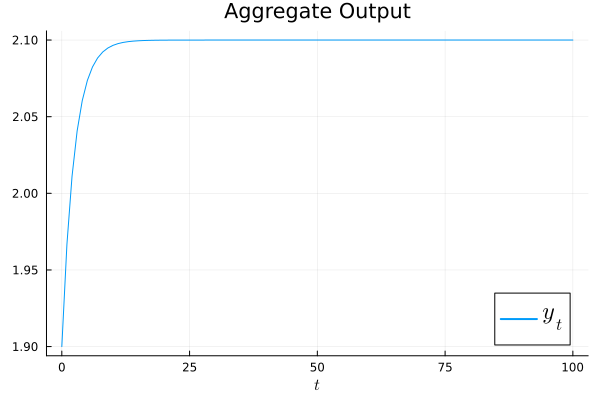

In [17]:
y_lim = y_limit(i_0, b, g_0)
Delta_g = 0.1
y_1 = calculate_y(i_0, b,
                  g_0 + Delta_g,
                  T, y_lim) 
plot(0: T, y_1, title = "Aggregate Output",
     size=(600,400), xlabel = L"t",
     label = L"y_t")

# Convergence and Uniqueness

## Fixed Point Theory

-   Fixed points, which will come about across a variety of places in
    economics
    -   Nash Equilibria, which requires fixed points of set-valued
        functions
    -   General Equilibrium
    -   Dynamic Programming - e.g., decision problems of macro agents
-   Frequently in quantitative macro you will rewrite problems as fixed
    points in order to demonstrate uniqueness, convergence, and use
    fixed-point algorithms to solve

## Convergence

-   For $v_{n+1} = f(v_n)$, take the limit for some $v_0$,

    $$
    \begin{aligned}
    v_1 &= f(v_0)\\
    v_2 &= f(v_1) = f(f(v_0))\\
    \ldots &\\
    \lim_{n\to\infty} v_n &= f(f(\ldots f((v_0)))) \stackrel{?}{\equiv} v^*
    \end{aligned}
    $$

    -   Does this limit exist for all $v_0$? (i.e, globally convergent)
    -   Does it exist “local” to any $v_0$? (i.e., locally convergent)

## Uniqueness

-   For $v_{n+1} = f(v_n)$, are there multiple fixed points?
    -   i.e., for some $v_0$ goes to $v^*_1$ and for some $v_0$ goes to
        $v^*_2$
-   Uniqueness should be interpreted in terms of economics
    -   Maybe non-uniqueness is interesting and leads to multiple
        equilibria (e.g., theories of growth where you can get stuck in
        a bad equilibria)
    -   Other times it says we wrote down the wrong model

## Fixed Point Theorems

-   A variety of fixed point theorems exist to show when solutions
    exist, and when solutions are unique
-   For us, we can look at an especially simple one which provides
    necessary and sufficient conditions for convergence and uniqueness
    -   [Banach’s fixed-point
        theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem)
    -   Useful because the proof is constructive (i.e., suggests
        algorithm)
    -   Gives us intuition on **contraction mappings**
-   Lets stay in 1-dimensions $f : \mathbb{R} \to \mathbb{R}$, but can
    be generalized

## Contraction Mappings

-   A **contraction mapping** is a function $f$ such that for some
    $0 < \beta < 1$ and all $x, y \in X$

    $$
    |f(x) - f(y)| \leq \beta |x - y|
    $$

    -   i.e., if I apply $f$ to two points, the distance between the two
        points shrinks by a factor of $\beta$

## Banach’s Fixed Point Theorem

If $f$ is a contraction mapping, then $f$ has a **unique** fixed point
$x^*$

-   Moreover, for any $x_0$, the sequence $x_0, x_1, \ldots$ defined by
    $x_{n+1} = f(x_n)$ converges to $x^*$
-   More generally: true on any on a complete metric space, but we won’t
    need to generalize

## Sketch of Proof

-   The proof is constructive, and gives us a way to find the fixed
    point

-   Start with $x_0 \in \mathbb{R}$ and define $x_{n+1} = f(x_n)$

-   Then, for $n \geq 1$

    $$
    \begin{aligned}
    |x_{n+1} - x_n| &= |f(x_n) - f(x_{n-1})| \leq \beta |x_n - x_{n-1}|\\
    &\leq \beta^2 |x_{n-1} - x_{n-2}| \leq \cdots \leq \beta^n |x_1 - x_0|
    \end{aligned}
    $$

-   Since $0 < \beta < 1$, the right hand side converges to zero as
    $n\to\infty$, independent of $x_0$

-   Hence the $|x_{n+1} - x_n|$ goes to zero, so $x_n = x_{n+1} \to x^*$
    as $n\to\infty$

    -   More subtle for fancier spaces $X$, but the same idea

## Proving Contraction Mappings

-   I won’t ask you to do proofs in this class, but useful to see how
    you might do it
-   Given this, a crucial tool is to be able to prove that a particular
    $f$ is a contraction mapping
-   Various ways to do this, and we will see connections to the
    gradient, $\nabla f(\cdot)$
-   One useful theorem are called [Blackwell’s Sufficiency
    Conditions](https://users.econ.umn.edu/~tkehoe/classes/BlackwellsConditions.pdf)
-   Sometimes it is easy to just apply the definition of **contraction
    mappings** directly

## Example for Linear Functions

-   Let $f(x) = a + b x$ for $a, b \in \mathbb{R}$

-   Substitute into the the definition of **contraction mapping**
    directly

    $$
    \begin{aligned}
    |f(x) - f(y)| &= |a + b x - (a + b y)| = |b| |x - y| \leq \beta |x - y|
    \end{aligned}
    $$

    -   So $f$ is a contraction mapping iff $\beta \equiv |b| < 1$
    -   Consequently, $f$ has a unique fixed point, $x^* = a + b x^*$

-   The multidimensional generalization of this checks the maximum
    absolute eigenvalue